In [13]:
from math import radians, degrees, sin, cos, atan, tan

mpilot  = 90   # kg (including harness and clothing = Hook-in weight)
h       = 1.2  # in m (hang strap length)

mwing   = 22   # kg (mass of wing)
Cmo     = 0.05
I       = 102  # in kg.m**2 according to G.V , I=110;% according to Cook study. Inertia Pilot+ Glider about CGTotal

AR      = 5.5  # Aspect ratio Falcon 5.5
K       = 0.7  # Cmq variable (from Methods for Estimating Stability and Control Derivatives for Standard Subsonic Airplanes (1973) -Roskam p51  )

S       = 15.8 # m^2 Falcon 170 area
c       = 1.9  # m Falcon 170
tpdist  = 8.5*c/100 # en m (distance between CGW et Tether point)
cgdist  = 0.06 # distance between tether point and the CGW
Clwa    = 3.5  # spanwise average value of the wing section lift curve slope (slope of CL between 5 and 15 degrees of alpha)
cbar    = 1.55 # distance between the apex of the downtubes and the control bar axis (optional)
        
Scx     = 0.16 # S.Cx of the pilot position. If prone : Scx=0.16. If stood: Scx=0.66
g       = 9.81 # N/kg or 
rho     = 1.22 # kg/m^3 density of air

M       = mpilot + mwing
phi     = radians(14)   # angle in degrees between the downtube and the axis perpendicular to the keel
sweep   = radians(31)   # Sweep angle at the quarterchord

# this should vary 0.4 if forward , -0.74 if backward
Lb = 0.4          # distance between the cgpilot and the axis of the control bar,if trim change 'Pil_act'
           
ksi  = atan(Lb/h) # angle between cg pilot and the downtubes


In [14]:
# use the gliderAC with added turning moments
# as similar to the matlab version as possible
import sympy as sp
import sympy.physics.mechanics as me

t = sp.Symbol('t')
g_symb           = sp.Symbol('g_s')  # necessary to have as a symbol rather than 9.81
x, z, theta      = me.dynamicsymbols('x z theta')        # position (x z) and orient pitch attitude (theta) of glider
v, gamma, thetav = me.dynamicsymbols('v gamma theta_v')  # velocity and direction of travel, and thetav=rate of change of direction of nose pitch attitude
xd, zd, thetad   = me.dynamicsymbols('x z theta', 1)
kinematic_equations = [ xd - v*sp.cos(gamma), zd - v*sp.sin(gamma), thetad - thetav ]

BaseFrame = me.ReferenceFrame('BaseFrame')
origin    = me.Point('origin')

# Glider positions TP=Tether Point, AC=Aerodynamic centre
GliderFrame = BaseFrame.orientnew('GliderFrame', 'Axis', [theta, BaseFrame.y])
gliderAC = origin.locatenew('gliderAC', x*BaseFrame.x + z*BaseFrame.z)
gliderAC.set_vel(BaseFrame, v*sp.cos(gamma)*BaseFrame.x + v*sp.sin(gamma)*BaseFrame.z)
#gliderAC.set_vel(BaseFrame, gliderAC.pos_from(origin).diff(t, BaseFrame))

# relative to gliderAC
gliderTPpos = tpdist*GliderFrame.x
gliderCGpos = (tpdist+cgdist)*GliderFrame.x
pilotCGpos  = h*(sp.sin(phi+ksi)*GliderFrame.x - sp.cos(phi+ksi)*GliderFrame.z)
combinedCGPos = (pilotCGpos*mpilot + gliderCGpos*mwing)/(mpilot+mwing)

alpha  = theta - gamma         # angle of attack
Clift  = -16.6*alpha**3 + 11.48*alpha**2 + 1.3*alpha + 0.038
Cdg    =  7.07*alpha**3 -  4.68*alpha**2 + 1.1*alpha - 0.0144
vsq    = v**2                  # airspeed square
lift   = 0.5*rho*vsq*S*Clift
Dcdg   = 0.5*rho*vsq*Cdg*S     # Drag of the wing alone
Dpilot = 0.5*rho*vsq*Scx       # Drag of the pilot alone
drag   = Dcdg + Dpilot         # Drag of the system (wing + pilot)
dyn    = 0.5*rho*vsq*S         # dynamic pressure

Cx  = -Dcdg;
Cy  = lift;

Xw  = combinedCGPos.dot(BaseFrame.x);
d   = combinedCGPos.magnitude()
Cmq = -K*Clwa*sp.cos(sweep)*((((1/24)*(AR**3*sp.tan(sweep)**2)/(AR + 6*sp.cos(sweep))) + 1/8) + (AR*(2*(Xw/c) + 0.5*(Xw/c))/(AR+2*sp.cos(sweep))))

Mq  = (Cmq*thetav*c**2*rho*v*S)/4
Mq2 = -0.5*rho*Cdg*S*(-2*thetav*d**2*v + thetav**2*d**3) 

Iyy = me.outer(GliderFrame.y, GliderFrame.y)*I
gliderbody = me.RigidBody( name="glider", masscenter=gliderAC, 
                          frame=GliderFrame,    mass=M, inertia=(Iyy, gliderAC))



In [15]:
#    CGW    = TP + cgdist*numpy.array([cos(fr), sin(fr)])  # CG of wing
#    CGP  = TP + h*numpy.array([sin(fr+phi+ksi), -cos(fr+phi+ksi)])  # CG of pilot
#    CGT  = (CGP*mpilot + CGW*mwing)/(mpilot + mwing)  # Position CG of the system (pilot+wing)
XWT = (gliderCGpos - combinedCGPos).dot(BaseFrame.x)
XP  = (pilotCGpos - combinedCGPos).dot(BaseFrame.x)
YP  = (pilotCGpos - combinedCGPos).dot(BaseFrame.z)
CGTx = combinedCGPos.dot(BaseFrame.x)
CGTy = combinedCGPos.dot(BaseFrame.z)

vecmotion = sp.cos(gamma)*BaseFrame.x + sp.sin(gamma)*BaseFrame.z
vecmotionPerp = -sp.sin(gamma)*BaseFrame.x + sp.cos(gamma)*BaseFrame.z
motionForce = -g_symb*M*BaseFrame.z - drag*vecmotion + lift*vecmotionPerp
turningForce = Cmo*dyn*c + mwing*g*XWT + mpilot*g*XP - Cy*CGTx - Cx*(-CGTy) - YP*Dpilot + Mq + Mq2
forces = [ (gliderAC, motionForce),
#           (GliderFrame, turningForce*GliderFrame.y)
         ]
bodies = [ gliderbody ]

KM = me.KanesMethod(BaseFrame, 
                     q_ind=[x, z, theta], 
                     u_ind=[v, gamma, thetav],
                     kd_eqs=kinematic_equations)
fr, frstar = KM.kanes_equations(bodies, forces)
#display(fr)
#display(frstar)


(array([ 0.        , -0.03910679]), array([0.        , 0.10739508]))

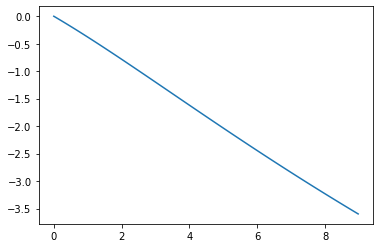

In [16]:

from pydy.system import System
import numpy as np
from sympy import Derivative

times = np.linspace(0.0, 1, 81)
initial_conditions = {x:0,      z:0,  theta:radians(10), 
                      v:9, gamma:radians(-10), thetav:0.}
sys = System(KM,
             constants={g_symb:g},
             initial_conditions=initial_conditions,
             times=times)
y1 = sys.integrate()

%matplotlib inline
import matplotlib.pyplot as plt

ax, az, atheta      = y1[:,0], y1[:,1], y1[:,2]
av, agamma, athetav = y1[:,3], y1[:,4], y1[:,5]

plt.plot(ax, az)
az[:2], ax[:2]


In [21]:
times[:2], az[:2]
az[1]/times[1], 9*sin(radians(10))*2

(-3.128543306659668, 3.125667198004746)

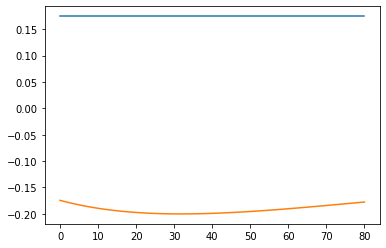

In [30]:
plt.plot(atheta)
plt.plot(agamma)
#plt.plot(agamma-atheta)


In [ ]:
plt.plot()

In [49]:
# Here is used for https://github.com/pydy/pydy/issues/428

import sympy as sp
import sympy.physics.mechanics as me
from pydy.system import System
import numpy as np

f = sp.Symbol('f')
t = sp.Symbol('t')
x, y, xv, yv = me.dynamicsymbols('x y xv yv')
xd, yd       = me.dynamicsymbols('x y', 1)
kd_eqs       = [ xd - xv, yd - yv ]

BaseFrame = me.ReferenceFrame('BaseFrame')
origin  = me.Point('origin')
bodycentre  = origin.locatenew('bodycentre', x*BaseFrame.x + y*BaseFrame.y)
bodycentre.set_vel(BaseFrame, bodycentre.pos_from(origin).diff(t, BaseFrame))

Izz = me.outer(BaseFrame.z, BaseFrame.z)*10
body = me.RigidBody(name="body", masscenter=bodycentre, 
                       frame=BaseFrame, mass=10, inertia=(Izz, bodycentre))

forces = [ (bodycentre, f*BaseFrame.x) ]
bodies = [ body ]

KM = me.KanesMethod(BaseFrame, q_ind=[x,y], u_ind=[xv,yv], kd_eqs=kd_eqs)
KM.kanes_equations(bodies, forces)

sys = System(KM,
             constants={f:0},
             initial_conditions={x:0, y:0, xv:4, yv:3},
             times=np.linspace(0.0, 1, 101))
y1 = sys.integrate()
y1.shape

y1[:2]

array([[0.  , 0.  , 4.  , 3.  ],
       [0.04, 0.03, 4.  , 3.  ]])

In [28]:
import sympy as sp
from math import radians
import sympy.physics.mechanics as me
from pydy.system import System
import numpy as np

f = sp.Symbol('f')
t = sp.Symbol('t')
x, y = me.dynamicsymbols('x y')          # cartesian position
v, gamma = me.dynamicsymbols('v gamma')  # polar velocity
xd, yd       = me.dynamicsymbols('x y', 1)
kd_eqs       = [ xd - v*sp.cos(gamma), 
                 yd - v*sp.sin(gamma) ]

BaseFrame = me.ReferenceFrame('BaseFrame')
origin  = me.Point('origin')
bodycentre  = origin.locatenew('bodycentre', x*BaseFrame.x + y*BaseFrame.y)

# either one will do
bodycentre.set_vel(BaseFrame, bodycentre.pos_from(origin).diff(t, BaseFrame))
#bodycentre.set_vel(BaseFrame, v*sp.cos(gamma)*BaseFrame.x + v*sp.sin(gamma)*BaseFrame.y)

Izz = me.outer(BaseFrame.z, BaseFrame.z)*10
body = me.RigidBody(name="body", masscenter=bodycentre, 
                       frame=BaseFrame, mass=10, inertia=(Izz, bodycentre))

forces = [ (bodycentre, f*BaseFrame.x) ]
bodies = [ body ]

KM = me.KanesMethod(BaseFrame, q_ind=[x,y], u_ind=[v,gamma], kd_eqs=kd_eqs)
fr, frstar = KM.kanes_equations(bodies, forces)

times = np.linspace(0.0, 1, 101)
sys = System(KM,
             constants={f:0},  # hardcoding f=0 causes issue #33
             initial_conditions={x:0, y:0, v:5, gamma:radians(90) },
             times=times)

y1 = sys.integrate()
print(times[:2])
y1[:2]

[0.   0.01]


array([[ 0.        ,  0.        ,  5.        ,  1.57079633],
       [-0.07853982,  0.05      ,  5.        ,  1.57079633]])

In [11]:
y1[:2]

array([[ 0.        ,  0.        ,  5.        ,  1.57079633],
       [-0.07853982,  0.05      ,  5.        ,  1.57079633]])

In [18]:
display(fr)

Matrix([
[            f*(-gamma(t)*sin(gamma(t)) + cos(gamma(t)))],
[f*(-gamma(t)*v(t)*cos(gamma(t)) - 2*v(t)*sin(gamma(t)))]])

In [19]:
display(frstar)

Matrix([
[                         -(10*(-gamma(t)*sin(gamma(t)) + cos(gamma(t)))*(-gamma(t)*v(t)*cos(gamma(t)) - 2*v(t)*sin(gamma(t))) + 10*(gamma(t)*cos(gamma(t)) + sin(gamma(t)))*(-gamma(t)*v(t)*sin(gamma(t)) + 2*v(t)*cos(gamma(t))))*Derivative(gamma(t), t) - (10*(-gamma(t)*sin(gamma(t)) + cos(gamma(t)))**2 + 10*(gamma(t)*cos(gamma(t)) + sin(gamma(t)))**2)*Derivative(v(t), t)],
[-(10*(-gamma(t)*sin(gamma(t)) + cos(gamma(t)))*(-gamma(t)*v(t)*cos(gamma(t)) - 2*v(t)*sin(gamma(t))) + 10*(gamma(t)*cos(gamma(t)) + sin(gamma(t)))*(-gamma(t)*v(t)*sin(gamma(t)) + 2*v(t)*cos(gamma(t))))*Derivative(v(t), t) - (10*(-gamma(t)*v(t)*sin(gamma(t)) + 2*v(t)*cos(gamma(t)))**2 + 10*(-gamma(t)*v(t)*cos(gamma(t)) - 2*v(t)*sin(gamma(t)))**2)*Derivative(gamma(t), t)]])

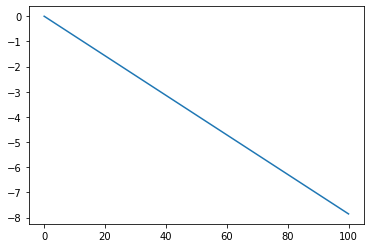

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(y1[:,0])